# San Francisco Crimen Classification
### Author: Cesar Gustavo Seminario Calle 

# Problem:
    From 1934 to 1963, San Francisco was infamous for housing some of the world's most notorious criminals on the inescapable island of Alcatraz.
    Today, the city is known more for its tech scene than its criminal past. But, with rising wealth inequality, housing shortages, and a proliferation of expensive digital toys riding BART to work, there is no scarcity of crime in the city by the bay.
    From Sunset to SOMA, and Marina to Excelsior, this competition's dataset provides nearly 12 years of crime reports from across all of San Francisco's neighborhoods. Given time and location, you must predict the category of crime that occurred

### Data fields
- Dates - timestamp of the crime incident
- Category - category of the crime incident (only in train.csv). This is the target variable you are going to predict.
- Descript - detailed description of the crime incident (only in train.csv)
- DayOfWeek - the day of the week
- PdDistrict - name of the Police Department District
- Resolution - how the crime incident was resolved (only in train.csv)
- Address - the approximate street address of the crime incident 
- X - Longitude
- Y - Latitude

## Importing Libraries and setting the data

In [1]:
import pandas as pd
import numpy as np
import scipy as sc
import seaborn as sns

train = pd.read_csv('../train.csv',parse_dates=['Dates'],dtype={'Address':'category'})
test = pd.read_csv('../test.csv', index_col='Id',parse_dates=['Dates'],dtype={'Address':'category'})

In [2]:
train.shape

(878049, 9)

In [3]:
train.info(all)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 878049 entries, 0 to 878048
Data columns (total 9 columns):
Dates         878049 non-null datetime64[ns]
Category      878049 non-null object
Descript      878049 non-null object
DayOfWeek     878049 non-null object
PdDistrict    878049 non-null object
Resolution    878049 non-null object
Address       878049 non-null category
X             878049 non-null float64
Y             878049 non-null float64
dtypes: category(1), datetime64[ns](1), float64(2), object(5)
memory usage: 56.1+ MB


In [4]:
test.shape

(884262, 6)

In [5]:
test.columns

Index(['Dates', 'DayOfWeek', 'PdDistrict', 'Address', 'X', 'Y'], dtype='object')

In [6]:
train.head()

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541


In [7]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 884262 entries, 0 to 884261
Data columns (total 6 columns):
Dates         884262 non-null datetime64[ns]
DayOfWeek     884262 non-null object
PdDistrict    884262 non-null object
Address       884262 non-null category
X             884262 non-null float64
Y             884262 non-null float64
dtypes: category(1), datetime64[ns](1), float64(2), object(2)
memory usage: 43.0+ MB


 # Exploratory Data Analysis
 ## Descriptive Analysis

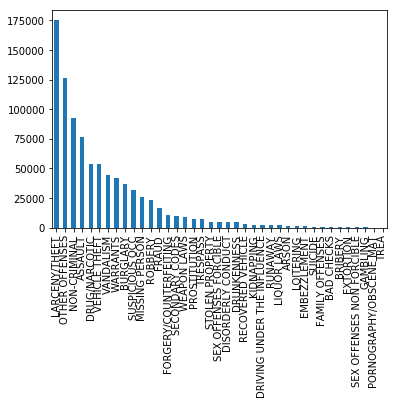

In [8]:
%matplotlib inline 
train.Category.value_counts().plot(kind='bar')

Larceny/Theft is the most frequent crime incident.

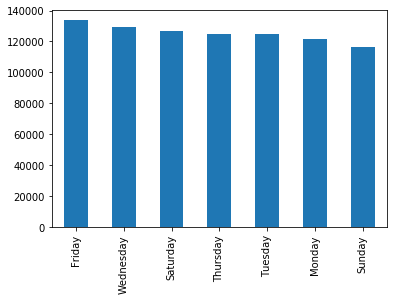

In [9]:
%matplotlib inline
train.DayOfWeek.value_counts().plot(kind='bar')

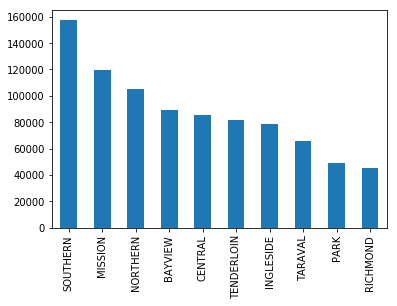

In [10]:
%matplotlib inline
train.PdDistrict.value_counts().plot(kind='bar')

In [11]:
test.columns, train.columns

(Index(['Dates', 'DayOfWeek', 'PdDistrict', 'Address', 'X', 'Y'], dtype='object'),
 Index(['Dates', 'Category', 'Descript', 'DayOfWeek', 'PdDistrict',
        'Resolution', 'Address', 'X', 'Y'],
       dtype='object'))

In [15]:
from sklearn.preprocessing import LabelEncoder
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest
import datetime

# Guardo los headers de Category para luego hacer el envio de la predicción
coder = LabelEncoder()
coder.fit(train['Category'])
header_predictions = coder.classes_


# Elimino las columnas que no existen en el test y separamos el 
train_y = train['Category']
train_X = train.drop(['Category','Descript','Resolution'],axis=1)







# Creo dos estimadores en scikit para splitear la fecha en año, mes, dias y hora
# el segundo es para convertir llas variables categoricas a numericas

class AddressSplitter(BaseEstimator, TransformerMixin):
    def __init__(self, name_col):
        self.name_col = name_col
        
    def fit(self,X=None, y=None):
        return self
    
    def transform(self,X=None,y=None):
        
        adr = X[self.name_col]
        X['Av']=adr.str[-2:]
        X =X.drop(self.name_col,axis = 1)
        return X  



class DateSplit(BaseEstimator, TransformerMixin):
    def __init__(self, name_col):
        self.name_col = name_col
        
    def fit(self,X=None, y=None):
        return self
    
    def transform(self,X=None,y=None):
        
        date = pd.DatetimeIndex(X[self.name_col])
        X['year'] = date.year
        X['month'] = date.month
        X['day'] = date.day
        X['hour'] = date.hour
        X = X.drop('Dates', axis=1)
        return X  
    
    
class ToNumeric(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.names=attribute_names
        
    def fit(self,X=None, y=None):
        return self
    
    def transform(self,X=None,y=None):
        for name in self.names:
            encoder = LabelEncoder()
            col_numeric= encoder.fit_transform(X[name])
            X.loc[:,name] = col_numeric
        return X
    
    
class TransformDummies(BaseEstimator, TransformerMixin):
    def __init__(self,col_to_dummies):
        self.col_names = col_to_dummies
        
    def fit(self,X=None, y=None):
        return self
    
    def transform(self,X=None, y = None):
        for name in self.col_names:
            dummies = pd.get_dummies(X[name],sparse=True)
            X = pd.concat([X,dummies],axis=1)
            X = X.drop(name, axis=1)
        return X
    
    

# attributes = ['Category','DayOfWeek', 'PdDistrict']
# estimator = ToNumeric(attributes)
# train_pr = estimator.transform(train_pr)

    


    We dropped the feature Descript because it has the same data as Category, 
    for now it doesnt seem to be useful for our problem.
    Then, We create an estimator base on scikit structure to encode the categoric attributes to    numeric format.


## Trying Models

In [16]:
from sklearn.linear_model import LogisticRegression
# 'year','month','day','hour'    
categoric_names = ['DayOfWeek','PdDistrict','year','month','hour','Av']


encoder = AddressSplitter('Address')
date_split = DateSplit('Dates')
dummies = TransformDummies(categoric_names)



pip_train = Pipeline([('split_address',encoder),('split_dates', date_split), ('dummies', dummies)])
data_prepared = pip_train.transform(train_X)



In [ ]:
from sklearn.feature_selection import RFECV

lg = LogisticRegression()
selector = RFECV(lg, cv=10)
selector.fit(data_prepared,train_y)
optimized_columns =data_prepared.columns[selector.support_]
optimized_columns

C:\Users\GIDEON\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:581: Warning: The least populated class in y has only 6 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


##  Testing

In [66]:
def submission(predictions, header_predictions,number):
    data_submissions = pd.get_dummies(predictions)
    print(data_submissions.columns)
    data_submissions.columns = header_predictions
    data_submissions.to_csv('submission_'+number+'.csv',index_label="Id")
    print(data_submissions.head())

In [55]:
from sklearn.pipeline import Pipeline
predictions_lg  = model_lg.predict(test_X)
predictions_lg



array(['OTHER OFFENSES', 'OTHER OFFENSES', 'LARCENY/THEFT', ...,
       'OTHER OFFENSES', 'OTHER OFFENSES', 'OTHER OFFENSES'], dtype=object)

In [65]:
predictions_lg

array(['OTHER OFFENSES', 'OTHER OFFENSES', 'LARCENY/THEFT', ...,
       'OTHER OFFENSES', 'OTHER OFFENSES', 'OTHER OFFENSES'], dtype=object)

In [67]:
submission(predictions_lg,header_predictions,'3')

Index(['ASSAULT', 'BURGLARY', 'DRUG/NARCOTIC', 'LARCENY/THEFT',
       'MISSING PERSON', 'NON-CRIMINAL', 'OTHER OFFENSES', 'PROSTITUTION',
       'VANDALISM', 'VEHICLE THEFT'],
      dtype='object')


ValueError: Length mismatch: Expected axis has 10 elements, new values have 39 elements

In [42]:
test_X=test_pr.drop('Dates',axis=1)
attributes = ['DayOfWeek', 'PdDistrict', 'Address']
estimator = ToNumeric(attributes)
test_X = estimator.transform(test_X)


In [43]:
predictions = rf.predict(test_X)
print(predictions)


[36 21 27 ...,  4 38 16]


In [44]:
test_X.columns, train_X.columns

(Index(['DayOfWeek', 'PdDistrict', 'Address', 'X', 'Y'], dtype='object'),
 Index(['DayOfWeek', 'PdDistrict', 'Address', 'X', 'Y'], dtype='object'))

In [55]:
data_submissions.head()

,0,1,2,3,4,5,6,7,8,9,...,29,30,31,32,33,34,35,36,37,38
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


(884262, 39)

In [ ]:
 #Selecting variables


In [ ]:


lr =LogisticRegression()
selector = RFECV(lr, cv=10)
selector.fit(all_X,all_y)
optimized_columns =all_X.columns[selector.support_]